# Постановка задачи

Есть тексты с меткой спам и не спам. Необходимо обучить модель классифицировать текст. Целевая метрика - ROC-AUC.

# Загрузка данных

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
from tqdm.auto import tqdm
from itertools import product
import random
import warnings

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import optuna
from optuna.samplers import TPESampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score)
from sklearn.metrics import (f1_score, classification_report, roc_auc_score, auc, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 1
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [4]:
train = pd.read_csv('train_spam.csv')
test = pd.read_csv('test_spam.csv')
print(train.shape)
print(test.shape)

(16278, 2)
(4070, 1)


In [5]:
train.sample(5)

,text_type,text
3160,ham,i hope you thats the result of being consisten...
4036,ham,grades thank you you have been wonderful to wo...
7301,ham,but if theres a steal deal on laptops do tell me
11829,spam,best cum all videos available here over newly ...
9921,ham,i wil leave sumthng 4u wen i wil leave dis wor...


In [6]:
test.sample(5)

,text
868,o to on your devices browse
955,i didnt get ur full msgsometext is missing sen...
1859,recruiting for weather risk management group h...
1119,organizational changes we are making a number ...
3359,hey anyway i have to


In [7]:
train.isnull().sum()

text_type    0
text         0
dtype: int64

In [8]:
print(train['text_type'].unique())
print(train['text_type'].value_counts())

['ham' 'spam']
ham     11469
spam     4809
Name: text_type, dtype: int64


In [9]:
test.isnull().sum()

text    0
dtype: int64

Задача бинарной классификации. Метки целевого класса: Spam - 1, ham - 0. Целевой класс несбалансирован. 

# Предобработка данных

In [10]:
train['target'] = train['text_type'].map({'spam': 1, 'ham': 0})

In [11]:
class_disbalance = round(len(train[train['target'] == 0])/len(train[train['target'] == 1]), 2)
class_disbalance

2.38

In [12]:
train.groupby('target').describe()

text_type                       text         \
           count unique   top   freq  count unique   
target                                               
0          11469      1   ham  11469  11469  11458   
1           4809      1  spam   4809   4809   4809   

                                                                
                                                      top freq  
target                                                          
0       SPAM ALERT  🚔  User:     Username: @DillyBubbl...    7  
1       plzz visit my website moviesgodml to get all m...    1

Посмотрю на облака слов необработанного текста.

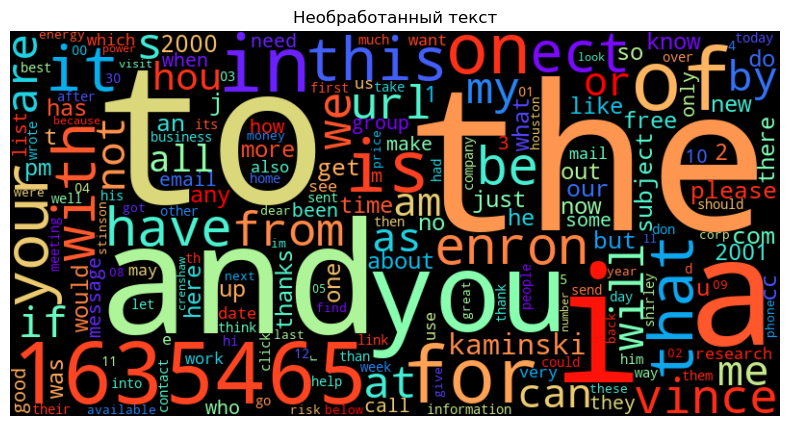

In [13]:
text_toxic = ' '.join(train['text'])
words = text_toxic.split()
word_freq = {}
for word in words:
    word_freq[word] = word_freq.get(word, 0) + 1
wordcloud = WordCloud(width=800, 
                      height=400,
                     colormap='rainbow').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Необработанный текст')
plt.axis("off")
plt.show()

## Лемматизация

В тектовых данных есть разделители, числа, символы, заглавные символы. Очищу данные и приведу к нижнему регистру. Удалю стоп-слова английского языка в тексте и лемматизирую текст.

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word.lower()) \
              for word in tokens if word.isalnum() and word.isalpha() and len(word)>3]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [16]:
train['text_clean'] = train['text'].apply(preprocess)

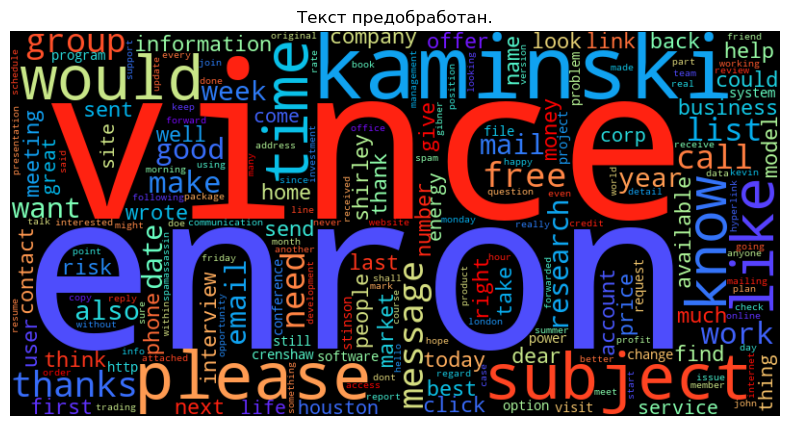

In [17]:
text_toxic = ' '.join(train['text_clean'])
words = text_toxic.split()
word_freq = {}
for word in words:
    word_freq[word] = word_freq.get(word, 0) + 1
wordcloud = WordCloud(width=800, 
                      height=400,
                     colormap='rainbow').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Текст предобработан.')
plt.show()

Максимальное количество слов в лемматизированном тексте - 94, будем это учитывать при векторизации.

In [18]:
train['text_clean'].duplicated().sum()

570

In [19]:
train[['text_clean', 'target']].duplicated().sum()

560

Есть дубликаты. Удалим их.

In [20]:
train = train.drop_duplicates(subset='text_clean')

In [21]:
# максимальная длина предобработанного текста
max(map(lambda text: len(text.split()), train['text_clean']))

94

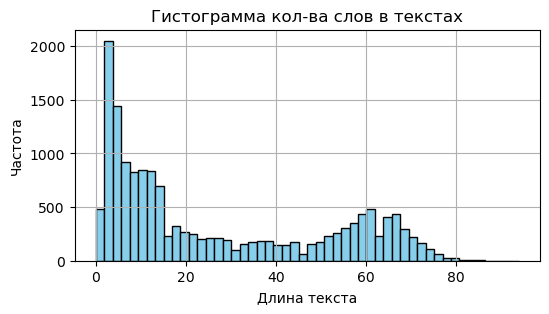

In [22]:
train['text_length'] = train['text_clean'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 3))
plt.hist(train['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Гистограмма кол-ва слов в текстах')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [23]:
word_counts = Counter()
for text in train['text_clean']:
    words = text.split()
    word_counts.update(words)
print('Наиболее часто встречающиеся слова:')
print(word_counts.most_common(20))
print('Количество уникальных слов:', len(word_counts))

Наиболее часто встречающиеся слова:
[('enron', 4793), ('vince', 4476), ('kaminski', 2337), ('please', 2321), ('subject', 2177), ('would', 2028), ('time', 2017), ('like', 1836), ('know', 1692), ('thanks', 1533), ('message', 1528), ('free', 1427), ('group', 1400), ('need', 1342), ('list', 1305), ('call', 1297), ('work', 1177), ('make', 1167), ('want', 1114), ('email', 1105)]
Количество уникальных слов: 39624


In [24]:
#очистка текста в тестовой выборке
test['text_clean'] = test['text'].apply(preprocess)

## Деление на выборки

Деление на выборки: train/test 90/10. Выбираю лучшую модель на кросс-валидации. Имеем несбалансированный целевой класс, метрика модели - f1, c beta=1.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train['text_clean'], 
                                                    train['target'], 
                                                    test_size=0.10,
                                                    stratify=train['target'],
                                                    random_state=RANDOM_STATE, shuffle=True)

## Векторизация текста

Для векторизации текста воспользуюсь методами TF-IFD, Word2Vec (из gensim) и Bert (unitary/toxic-bert, обучен на спам-текстах).

### TF-IDF векторизация

In [26]:
tfidf = TfidfVectorizer(min_df=1e-3,
                        max_df=0.8,
                        ngram_range=(1, 5),
                        use_idf=True,
                        smooth_idf=True,
                        norm='l2')

In [27]:
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

print('Tfidf_train:', tfidf_train.shape)
print('Tfidf_test:', tfidf_test.shape)

Tfidf_train: (14137, 5197)
Tfidf_test: (1571, 5197)


Примерно ~5к признаков. Данных ~ 16к.

In [28]:
#количество ненулевых значений в матрице для обучения
print('Кол-во ненулевых значений:', tfidf_train.nnz)
print('Разряженность матрицы: {:.2f} %'.format(
    tfidf_train.nnz*100/(tfidf_train.shape[0]*tfidf_train.shape[1])))

Кол-во ненулевых значений: 292088
Разряженность матрицы: 0.40 %


### Word2Vec

Воспользуюсь предобученной моделью word2vec от google из б-ки gensim.

In [29]:
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=120, window=2, min_count=10, workers=5)

In [30]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(120)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

w2v_train = np.array([vectorize(sentence) for sentence in X_train])
w2v_test = np.array([vectorize(sentence) for sentence in X_test])

### Bert

Реализацию с предобученной моделью Bert для спам-текстов не удалось запустить даже на kaggle... 

In [31]:
#bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [32]:
#def tokenize_text_bert(text):
#    inputs = bert_tokenizer(text, padding=True, max_length=512, truncation=True, return_tensors="pt")
#    return inputs

In [33]:
#bert_train = np.array([bert_tokenizer(sentence) for sentence in X_train])
#bert_test = np.array([bert_tokenizer(sentence) for sentence in X_test])

In [34]:
#bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

## Обучение модели

In [35]:
def objective(trial, model, params, X_train, y_train, cv):
    for param, options in params.items():
        if isinstance(options, tuple):
            trial_value = trial.suggest_int(param, options[0], options[-1])
        else:
            trial_value = trial.suggest_categorical(param, options)
        model.set_params(**{param: trial_value})
    pipeline = Pipeline(steps=[('model', model)])
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    return f1_scores.mean()

In [36]:
def model_train(trials, model, params, X_train, y_train, cv):
    sampler = TPESampler(seed=RANDOM_STATE)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    optimize_func = lambda trial: objective(trial=trial, 
                                            model=model,
                                            params=params, 
                                            X_train=X_train, 
                                            y_train=y_train, cv=cv) 
    with tqdm(total=trials) as pbar:
        def callback(study, trial):
            pbar.update(1)
    
        study.optimize(optimize_func, n_trials=trials, callbacks=[callback])
    print('Наиучшая метрика:', round(study.best_value, 3))
    print('Лучшие параметры модели:', study.best_params)
    
    return study.best_params, study.best_value

### Const-model

In [37]:
#предсказание случайным образом 0, 1
y_pred = np.random.randint(2, size=len(y_train))
score_baseline = roc_auc_score(y_train, y_pred)
print("ROC-AUC:", round(score_baseline, 3))

ROC-AUC: 0.506


In [38]:
#датафрейм с результатами
results = pd.DataFrame([], columns=['model', 'params', 'ROC-AUC', 'vec_method'])

In [39]:
results.loc[len(results.index)] = ['baseline', [], score_baseline, '']
results

,model,params,ROC-AUC,vec_method
0,baseline,[],0.506204,


In [40]:
results

,model,params,ROC-AUC,vec_method
0,baseline,[],0.506204,


### LogisticRegression()

In [41]:
model = LogisticRegression()
lr_params = {'C': (0, 1000), 'penalty': ['l1', 'l2'], 'max_iter': (100, 1000), 
              'solver': ['liblinear', 'liblinear'], 'random_state': [RANDOM_STATE],
              'class_weight' : ['balanced', None]}

In [42]:
lr_best_params, lr_best_score = model_train(trials=10, model=model,
                                            params=lr_params, 
                                            X_train=tfidf_train, 
                                            y_train=y_train, cv=10)

[I 2024-05-03 12:47:53,384] A new study created in memory with name: no-name-ad93fdfb-b2e8-408e-ab5b-d465f8889804


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-03 12:47:54,679] Trial 0 finished with value: 0.9220481996279375 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 372, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 0 with value: 0.9220481996279375.
[I 2024-05-03 12:47:55,906] Trial 1 finished with value: 0.9224119522952735 and parameters: {'C': 397, 'penalty': 'l1', 'max_iter': 717, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9224119522952735.
[I 2024-05-03 12:47:57,123] Trial 2 finished with value: 0.9220481996279375 and parameters: {'C': 417, 'penalty': 'l1', 'max_iter': 278, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9224119522952735.
[I 2024-05-03 12:47:58,619] Trial 3 finished with value: 0.9182556382368837 and parameters: {'C': 877, 'penalty': 'l1', 'max_iter': 135, 'solver': 'liblinear', 'random_state': 1, 'class_weight': None}. Best is trial 1 with value: 0.9224119522952735.


Наиучшая метрика: 0.958
Лучшие параметры модели: {'C': 50, 'penalty': 'l2', 'max_iter': 563, 'solver': 'liblinear', 'random_state': 1, 'class_weight': 'balanced'}


In [43]:
results.loc[len(results.index)] = [LogisticRegression(), lr_best_params, lr_best_score, 'tf-idf']

### RandomForest

In [44]:
model = RandomForestClassifier()
rf_params = {'n_estimators': (20, 350), 'max_depth': (2, 50), 'class_weight':['balanced', None],
              'min_impurity_decrease': (0.0, 1.0), 'min_samples_split': (2, 50), 'min_samples_leaf': (1, 50),
              'random_state': [RANDOM_STATE]}
rf_best_params, rf_best_score = model_train(trials=25, model=model, 
                                            params=rf_params, X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 12:48:06,345] A new study created in memory with name: no-name-62d9c6bc-e8d3-4738-af11-f1d9ae523aaa


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-05-03 12:48:10,552] Trial 0 finished with value: 0.9342161080245006 and parameters: {'n_estimators': 158, 'max_depth': 37, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 6, 'min_samples_leaf': 10, 'random_state': 1}. Best is trial 0 with value: 0.9342161080245006.
[I 2024-05-03 12:48:11,372] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 134, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 1, 'min_samples_split': 12, 'min_samples_leaf': 44, 'random_state': 1}. Best is trial 0 with value: 0.9342161080245006.
[I 2024-05-03 12:48:11,969] Trial 2 finished with value: 0.9136847480526165 and parameters: {'n_estimators': 29, 'max_depth': 34, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 11, 'min_samples_leaf': 41, 'random_state': 1}. Best is trial 0 with value: 0.9342161080245006.
[I 2024-05-03 12:48:14,034] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 340, 'max_depth': 17, '

Наиучшая метрика: 0.947
Лучшие параметры модели: {'n_estimators': 215, 'max_depth': 40, 'class_weight': 'balanced', 'min_impurity_decrease': 0, 'min_samples_split': 8, 'min_samples_leaf': 6, 'random_state': 1}


In [45]:
results.loc[len(results.index)] = [RandomForestClassifier(), rf_best_params, rf_best_score, 'tf-idf']

In [46]:
rf_best_params, rf_best_score = model_train(trials=25, model=model, 
                                            params=rf_params, X_train=w2v_train, y_train=y_train, cv=5)
results.loc[len(results.index)] = [RandomForestClassifier(), rf_best_params, rf_best_score, 'w2v']

[I 2024-05-03 12:49:45,180] A new study created in memory with name: no-name-79b9e40a-d0f9-4ac3-a548-a60ac2dd0e08


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-05-03 12:50:32,996] Trial 0 finished with value: 0.9416741973699345 and parameters: {'n_estimators': 158, 'max_depth': 37, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 6, 'min_samples_leaf': 10, 'random_state': 1}. Best is trial 0 with value: 0.9416741973699345.
[I 2024-05-03 12:50:38,029] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 134, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 1, 'min_samples_split': 12, 'min_samples_leaf': 44, 'random_state': 1}. Best is trial 0 with value: 0.9416741973699345.
[I 2024-05-03 12:50:44,929] Trial 2 finished with value: 0.9294687920556186 and parameters: {'n_estimators': 29, 'max_depth': 34, 'class_weight': None, 'min_impurity_decrease': 0, 'min_samples_split': 11, 'min_samples_leaf': 41, 'random_state': 1}. Best is trial 0 with value: 0.9416741973699345.
[I 2024-05-03 12:50:57,708] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 340, 'max_depth': 17, '

Наиучшая метрика: 0.943
Лучшие параметры модели: {'n_estimators': 196, 'max_depth': 21, 'class_weight': 'balanced', 'min_impurity_decrease': 0, 'min_samples_split': 20, 'min_samples_leaf': 6, 'random_state': 1}


### MultinomialNB

In [47]:
model = MultinomialNB() 
nb_params = {
    'alpha': (0.1, 100),
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7], [0.6, 0.4], [0.4, 0.6], [0.7, 0.3], [0.2, 0.8], [0.8, 0.2]] 
}
nb_best_params, nb_best_score = model_train(trials=20, model=model,
                                            params=nb_params, 
                                            X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 13:09:08,408] A new study created in memory with name: no-name-6da46b26-9d59-4f2e-a114-d631c42255fa


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 13:09:08,435] Trial 0 finished with value: 0.9154831957966652 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': [0.8, 0.2]}. Best is trial 0 with value: 0.9154831957966652.
[I 2024-05-03 13:09:08,457] Trial 1 finished with value: 0.9154831957966652 and parameters: {'alpha': 42, 'fit_prior': True, 'class_prior': None}. Best is trial 0 with value: 0.9154831957966652.
[I 2024-05-03 13:09:08,478] Trial 2 finished with value: 0.905783424328507 and parameters: {'alpha': 80, 'fit_prior': True, 'class_prior': [0.6, 0.4]}. Best is trial 0 with value: 0.9154831957966652.
[I 2024-05-03 13:09:08,499] Trial 3 finished with value: 0.9432190826584271 and parameters: {'alpha': 9, 'fit_prior': False, 'class_prior': [0.7, 0.3]}. Best is trial 3 with value: 0.9432190826584271.
[I 2024-05-03 13:09:08,521] Trial 4 finished with value: 0.9030991073467696 and parameters: {'alpha': 99, 'fit_prior': True, 'class_prior': [0.4, 0.6]}. Best is trial 3 with value: 0.9432190826584271.
[I

Наиучшая метрика: 0.961
Лучшие параметры модели: {'alpha': 1, 'fit_prior': True, 'class_prior': [0.8, 0.2]}


In [48]:
results.loc[len(results.index)] = [MultinomialNB(), nb_best_params, nb_best_score, 'tf-idf']

### LinearSVC

In [49]:
model = LinearSVC()
params = {
    'C': (0, 100),
    'max_iter': (100, 1000),
    'random_state': [RANDOM_STATE],
    'penalty': ['l2'],
    'tol': [1e-3],
    'class_weight': [None, 'balanced']
}
lsvc_best_params, lsvc_best_score = model_train(trials=20, model=model,
                                                params=params, X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 13:09:08,882] A new study created in memory with name: no-name-0dcbab4c-2c9a-4d5c-8cfe-051cf3d86d6e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 13:09:09,522] Trial 0 finished with value: 0.9327123518060667 and parameters: {'C': 42, 'max_iter': 749, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9327123518060667.
[I 2024-05-03 13:09:09,753] Trial 1 finished with value: 0.9440036047756525 and parameters: {'C': 14, 'max_iter': 183, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9440036047756525.
[I 2024-05-03 13:09:10,279] Trial 2 finished with value: 0.9332331024527891 and parameters: {'C': 40, 'max_iter': 585, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9440036047756525.
[I 2024-05-03 13:09:11,021] Trial 3 finished with value: 0.9400420093136292 and parameters: {'C': 20, 'max_iter': 891, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9440036047756525.
[I 2024-05-03 13

Наиучшая метрика: 0.963
Лучшие параметры модели: {'C': 1, 'max_iter': 174, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': None}


In [50]:
results.loc[len(results.index)] = [LinearSVC(), lsvc_best_params, lsvc_best_score, 'tf-idf'] 

In [51]:
lsvc_best_params, lsvc_best_score = model_train(trials=20, model=LinearSVC(),
                                                params=params, X_train=w2v_train, y_train=y_train, cv=5)

[I 2024-05-03 13:09:17,473] A new study created in memory with name: no-name-f17b2b7f-9f97-4708-9760-b648b955bc3a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 13:09:29,228] Trial 0 finished with value: 0.9087689612115529 and parameters: {'C': 42, 'max_iter': 749, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9087689612115529.
[I 2024-05-03 13:09:32,727] Trial 1 finished with value: 0.9040987249911041 and parameters: {'C': 14, 'max_iter': 183, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9087689612115529.
[I 2024-05-03 13:09:42,023] Trial 2 finished with value: 0.9034678199516316 and parameters: {'C': 40, 'max_iter': 585, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9087689612115529.
[I 2024-05-03 13:09:57,879] Trial 3 finished with value: 0.9108265655323702 and parameters: {'C': 20, 'max_iter': 891, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.9108265655323702.
[I 2024-05-03 13

Наиучшая метрика: 0.911
Лучшие параметры модели: {'C': 10, 'max_iter': 669, 'random_state': 1, 'penalty': 'l2', 'tol': 0.001, 'class_weight': 'balanced'}


In [52]:
results.loc[len(results.index)] = [LinearSVC(), lsvc_best_params, lsvc_best_score, 'w2v']

### LGBMClassifier

In [53]:
model = LGBMClassifier()
params = {'n_estimators': (100, 1000), 
          'learning_rate': [0.01, 0.05, 0.1], 
          'max_depth': (2, 50), 
          'reg_lambda': (0.2, 1), 
          'reg_alpha': (0.2, 1),
          'random_state': [RANDOM_STATE], 'boosting_type':['gbdt'], 'verbose':[-1]}

lgbm_best_params, lgbm_best_score = \
    model_train(trials=20, model=model, params=params, X_train=tfidf_train, y_train=y_train, cv=5)

[I 2024-05-03 13:13:07,768] A new study created in memory with name: no-name-18e50a42-9bb0-4698-aca1-a9a5374590f5


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 13:13:18,728] Trial 0 finished with value: 0.9281811221418206 and parameters: {'n_estimators': 475, 'learning_rate': 0.01, 'max_depth': 9, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 0 with value: 0.9281811221418206.
[I 2024-05-03 13:13:35,789] Trial 1 finished with value: 0.9613887983918593 and parameters: {'n_estimators': 411, 'learning_rate': 0.05, 'max_depth': 35, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9613887983918593.
[I 2024-05-03 13:13:38,809] Trial 2 finished with value: 0.8728814868637395 and parameters: {'n_estimators': 124, 'learning_rate': 0.01, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9613887983918593.
[I 2024-05-03 13:14:08,737] Trial 3 finished with value: 0.9568812711579369 and parameters: {'n_estimators': 972, 'le

Наиучшая метрика: 0.961
Лучшие параметры модели: {'n_estimators': 522, 'learning_rate': 0.1, 'max_depth': 25, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}


In [54]:
results.loc[len(results.index)] = [LGBMClassifier(), lgbm_best_params, lgbm_best_score, 'tf-idf']

In [55]:
lgbm_best_params, lgbm_best_score = \
    model_train(trials=20, model=LGBMClassifier(), params=params, X_train=w2v_train, y_train=y_train, cv=5)

results.loc[len(results.index)] = [LGBMClassifier(), lgbm_best_params, lgbm_best_score, 'w2v']

[I 2024-05-03 13:19:06,827] A new study created in memory with name: no-name-b9e40f32-4803-48e9-8786-49ccb17fdf27


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-03 13:19:16,575] Trial 0 finished with value: 0.9440425964372026 and parameters: {'n_estimators': 475, 'learning_rate': 0.01, 'max_depth': 9, 'reg_lambda': 0, 'reg_alpha': 0, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 0 with value: 0.9440425964372026.
[I 2024-05-03 13:19:27,180] Trial 1 finished with value: 0.9501414231149262 and parameters: {'n_estimators': 411, 'learning_rate': 0.05, 'max_depth': 35, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9501414231149262.
[I 2024-05-03 13:19:30,786] Trial 2 finished with value: 0.92793586510898 and parameters: {'n_estimators': 124, 'learning_rate': 0.01, 'max_depth': 8, 'reg_lambda': 0, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}. Best is trial 1 with value: 0.9501414231149262.
[I 2024-05-03 13:19:52,267] Trial 3 finished with value: 0.9494912647234919 and parameters: {'n_estimators': 972, 'lear

Наиучшая метрика: 0.951
Лучшие параметры модели: {'n_estimators': 601, 'learning_rate': 0.05, 'max_depth': 31, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 1, 'boosting_type': 'gbdt', 'verbose': -1}


## Лучшая модель

In [56]:
results = results.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
results

,model,params,ROC-AUC,vec_method
0,LinearSVC(),"{'C': 1, 'max_iter': 174, 'random_state': 1, '...",0.963213,tf-idf
1,LGBMClassifier(),"{'n_estimators': 522, 'learning_rate': 0.1, 'm...",0.961413,tf-idf
2,MultinomialNB(),"{'alpha': 1, 'fit_prior': True, 'class_prior':...",0.961264,tf-idf
3,LogisticRegression(),"{'C': 50, 'penalty': 'l2', 'max_iter': 563, 's...",0.958453,tf-idf
4,LGBMClassifier(),"{'n_estimators': 601, 'learning_rate': 0.05, '...",0.950593,w2v
5,RandomForestClassifier(),"{'n_estimators': 215, 'max_depth': 40, 'class_...",0.946787,tf-idf
6,RandomForestClassifier(),"{'n_estimators': 196, 'max_depth': 21, 'class_...",0.943226,w2v
7,LinearSVC(),"{'C': 10, 'max_iter': 669, 'random_state': 1, ...",0.911261,w2v
8,baseline,[],0.506204,


Лучшая модель - модель, обученная с использованием метода опорных векторов LinearSVC(), с использованием метода векторизации текста tf-idf. Модели, обученные на данных, векторизованных методом tf-idf, продемонстрировали более высокие результаты, чем модели, обучающая выборка которых векторизовалась с помощью Word2Vec из gensim. Характеристики модели на тестовой выборке следующие. 

In [57]:
best_model = results['model'][0].set_params(**results['params'][0])
best_model.fit(tfidf_train, y_train)
y_pred = best_model.predict(tfidf_test)

print("На тестовых данных ROC-AUC лучшей модели:", round(roc_auc_score(y_test, y_pred), 3))

На тестовых данных ROC-AUC лучшей модели: 0.898


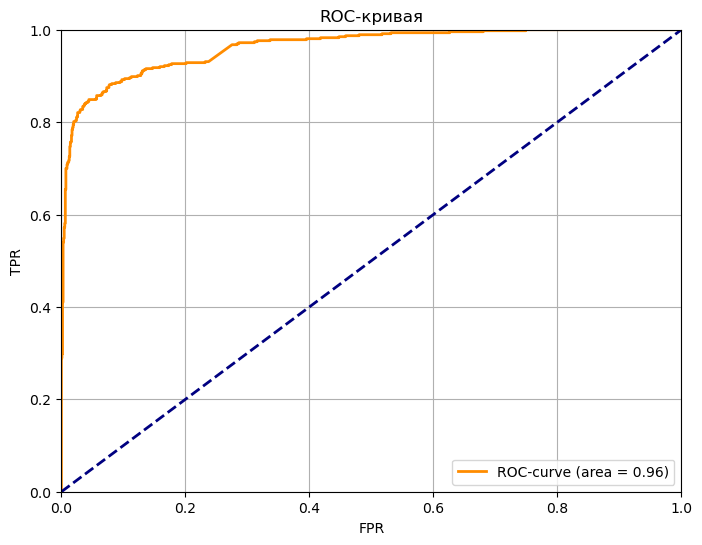

In [60]:
probabilities = best_model.decision_function(tfidf_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC-curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

ROC-кривая близка к идеальной, площадь под ROC-кривой -0.96.

In [61]:
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1108
           1       0.92      0.83      0.87       463

    accuracy                           0.93      1571
   macro avg       0.93      0.90      0.91      1571
weighted avg       0.93      0.93      0.93      1571



Построим матрицу ошибок. Результаты модели хорошие, целевой класс "спам" ожидаемо определяется чуть хуже (recall ниже).

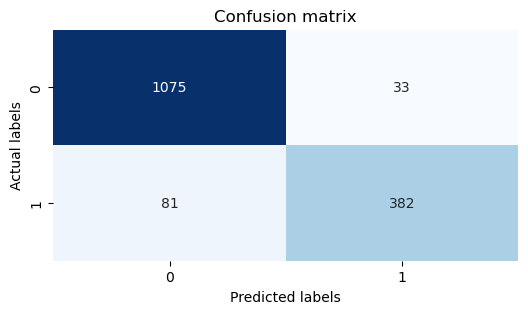

In [62]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion matrix')
plt.show()

In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
print("False Positive Rate (FPR):", round(fpr*100), '%')
print("False Negative Rate (FNR):", round(fnr*100), '%')

False Positive Rate (FPR): 3 %
False Negative Rate (FNR): 17 %


Метрика лучшей модели на тестовых данных *ROC-AUC=0.90*. Процент ошибок второго рода у модели выше, чем процент ошибок первого рода: модель чаще ошибается, определяя спам-текст как не спам, чем определяя неспам-текст как спам.

## Экспорт результатов

Для данных test сформируем csv-файл со следующим содержание: исходный текст - метка (ham, spam). test (дата-фрейм) уже содержит очищенный и лемматизированный текст - text_clean. Применим векторизацию и подставим данные в модель.

In [64]:
test.sample()

,text,text_clean
702,greetings hi mr kaminski how are you i am back...,greeting kaminski back school semester contact...


In [65]:
vec_test = tfidf.transform(test['text_clean'])
predicted_labels = best_model.predict(vec_test)
test['score'] = predicted_labels

In [66]:
test['score'] = test['score'].map({1:'spam', 0:'ham'})

In [67]:
res_test = test[['score', 'text']]
res_test.sample()

,score,text
1818,spam,rats hey did u ever vote for the next themes


In [68]:
res_test.to_csv('test_results.csv', index=False)